In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval[torch]
except Exception:
    pass

In [2]:
# You will need matplotlib for visualing your results and numpy to be able to handle the data.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# You will only use torchvision to load in the dataset.
# If you already have the data stored on your computer in a numpy friendly manner,
# then feel free to load it directly into numpy arrays.
import torchvision.transforms.v2 as v2
from torchvision import datasets

# Load the classes from DataEval that are helpful for bias
from dataeval.metrics.bias import balance, diversity, parity

In [3]:
# Creating a helper plotting function
def heatmap(
    data,
    row_labels,
    col_labels,
    xlabel="",
    ylabel="",
    top=True,
    cbarlabel="",
    valfmt=None,
    textkw=None,
    **kwargs,
):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the heatmap
    im = ax.imshow(data, vmin=0, vmax=1.0, **kwargs)

    # Create colorbar
    cbar = fig.colorbar(im, shrink=0.5)
    cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
    cbar.set_ticklabels(["0.0", "0.25", "0.5", "0.75", "1.0"])
    cbar.set_label(cbarlabel, loc="center")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    if top:
        ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")
    else:
        ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    # Get the formatter in case a string is supplied
    if valfmt and isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)  # type: ignore
    else:
        valfmt = matplotlib.ticker.FuncFormatter(func)  # type: ignore

    # Normalize the threshold to the images color range.
    threshold = im.norm(1.0) / 2.0

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = {"horizontalalignment": "center", "verticalalignment": "center"}
    if textkw:
        kw.update(textkw)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    textcolors = ("white", "black")
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)  # type: ignore
            texts.append(text)

    fig.tight_layout()
    plt.show()


# Function to define how the text is displayed in the heatmap
def func(x, pos):
    return f"{x:.2f}".replace("0.00", "0").replace("0.", ".").replace("nan", "")

In [4]:
# Download the data and then load it as a torch Tensor.
to_tensor = v2.ToImage()
ds = datasets.VOCDetection(root="./data", year="2011", image_set="train", download=True, transform=to_tensor)

Using downloaded and verified file: ./data/VOCtrainval_25-May-2011.tar
Extracting ./data/VOCtrainval_25-May-2011.tar to ./data


In [5]:
# Verify the size of the loaded dataset
len(ds)

5717

In [6]:
# Check the label structure
ds[0][1]

{'annotation': {'folder': 'VOC2011',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

In [7]:
metadata_dict = {
    "database": [],
    "image": [],
    "width": [],
    "height": [],
    "channels": [],
    "segmented": [],
    "pose": [],
    "truncated": [],
    "occluded": [],
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": [],
    "difficult": [],
}

class_labels = []

for data in ds:
    base = data[1]["annotation"]
    objects = base["object"]
    for obj in objects:
        # Append each value to the corresponding list in the metadata_dict
        metadata_dict["database"].append(base["source"]["database"])
        metadata_dict["image"].append(base["source"]["image"])
        metadata_dict["width"].append(int(base["size"]["width"]))
        metadata_dict["height"].append(int(base["size"]["height"]))
        metadata_dict["channels"].append(int(base["size"]["depth"]))
        metadata_dict["segmented"].append(int(base["segmented"]))
        metadata_dict["pose"].append(obj["pose"])
        metadata_dict["truncated"].append(int(obj["truncated"]))
        metadata_dict["occluded"].append(int(obj["occluded"]))
        metadata_dict["xmin"].append(int(obj["bndbox"]["xmin"]))
        metadata_dict["ymin"].append(int(obj["bndbox"]["ymin"]))
        metadata_dict["xmax"].append(int(obj["bndbox"]["xmax"]))
        metadata_dict["ymax"].append(int(obj["bndbox"]["ymax"]))
        metadata_dict["difficult"].append(int(obj["difficult"]))
        class_labels.append(obj["name"])

In [8]:
# Verify that the lengths match
print(len(class_labels), len(metadata_dict["database"]))

15774 15774


In [9]:
min_count = 50

for continuous_variable in ["width", "height", "channels", "xmin", "ymin", "xmax", "ymax"]:
    counts, bin_edges = np.histogram(metadata_dict[continuous_variable], bins="auto")

    if counts.min() < min_count:
        new_counts = []
        new_bin_edges = [bin_edges[0]]

        current_count = 0
        for i in range(len(counts)):
            current_count += counts[i]

            if current_count >= min_count:
                new_counts.append(current_count)
                new_bin_edges.append(bin_edges[i + 1])
                current_count = 0

        if current_count > 0:
            new_counts[-1] += current_count

        if counts[-1] < min_count:
            new_bin_edges[-1] = bin_edges[-1] + 1

        # Output the adjusted histogram
        new_counts = np.array(new_counts)
        new_bin_edges = np.array(new_bin_edges)

        discretized_variable = np.digitize(metadata_dict[continuous_variable], bins=new_bin_edges, right=False)

    else:
        discretized_variable = np.digitize(metadata_dict[continuous_variable], bins=bin_edges, right=False)

    metadata_dict[continuous_variable] = list(discretized_variable)

In [10]:
keys = metadata_dict.keys()
metadata = [dict(zip(keys, values)) for values in zip(*metadata_dict.values())]
print(len(metadata))

class_list, numerical_labels = np.unique(class_labels, return_inverse=True)
print(len(numerical_labels))

15774
15774


In [11]:
bal = balance(list(numerical_labels), metadata)

In [12]:
# Combine balance and factors results
data = np.concatenate([bal.balance[np.newaxis, 1:], bal.factors], axis=0)
# Create a mask for the upper triangle of the symmetrical array, ignoring the diagonal
mask = np.triu(data + 1, k=0) < 1
# Finalize the data for the plot, last row is just last factor x last factor so it gets dropped
heat_data = np.where(mask, np.nan, data)[:-1]
# Creating label array for heat map axes
heat_labels = ["class"] + list(metadata_dict.keys())

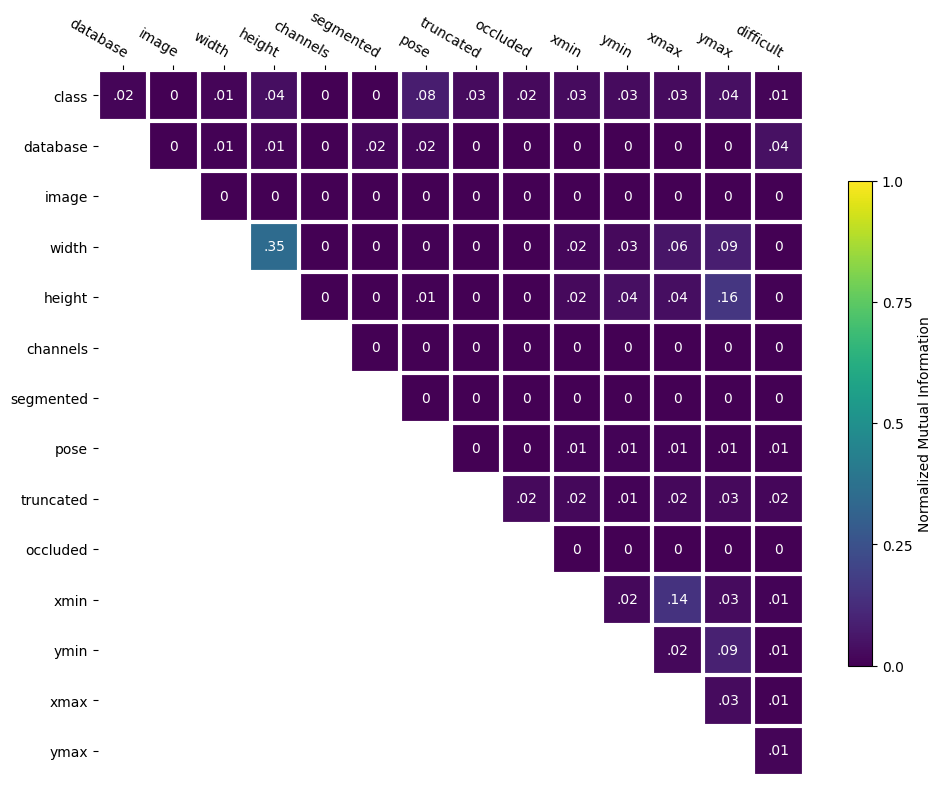

In [13]:
heatmap(heat_data, heat_labels[:-1], heat_labels[1:], cbarlabel="Normalized Mutual Information")

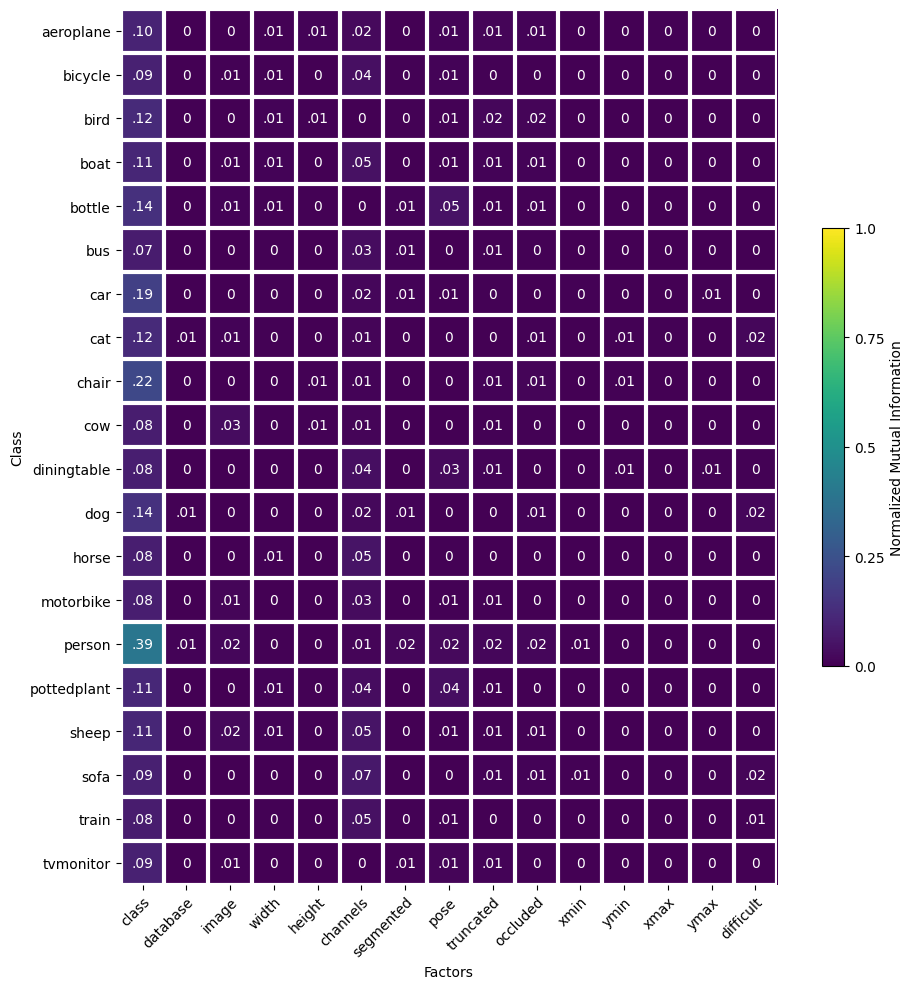

In [14]:
heatmap(
    bal.classwise,
    class_list,
    heat_labels,
    xlabel="Factors",
    ylabel="Class",
    top=False,
    cbarlabel="Normalized Mutual Information",
)

In [15]:
div = diversity(list(numerical_labels), metadata)

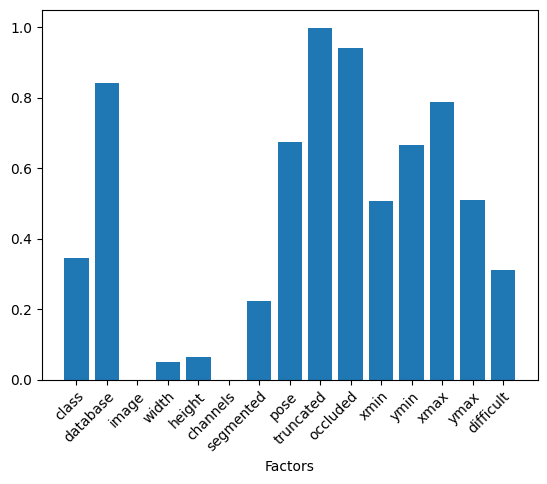

In [16]:
fig, ax = plt.subplots()
ax.bar(heat_labels, div.diversity_index)
ax.set_xlabel("Factors")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

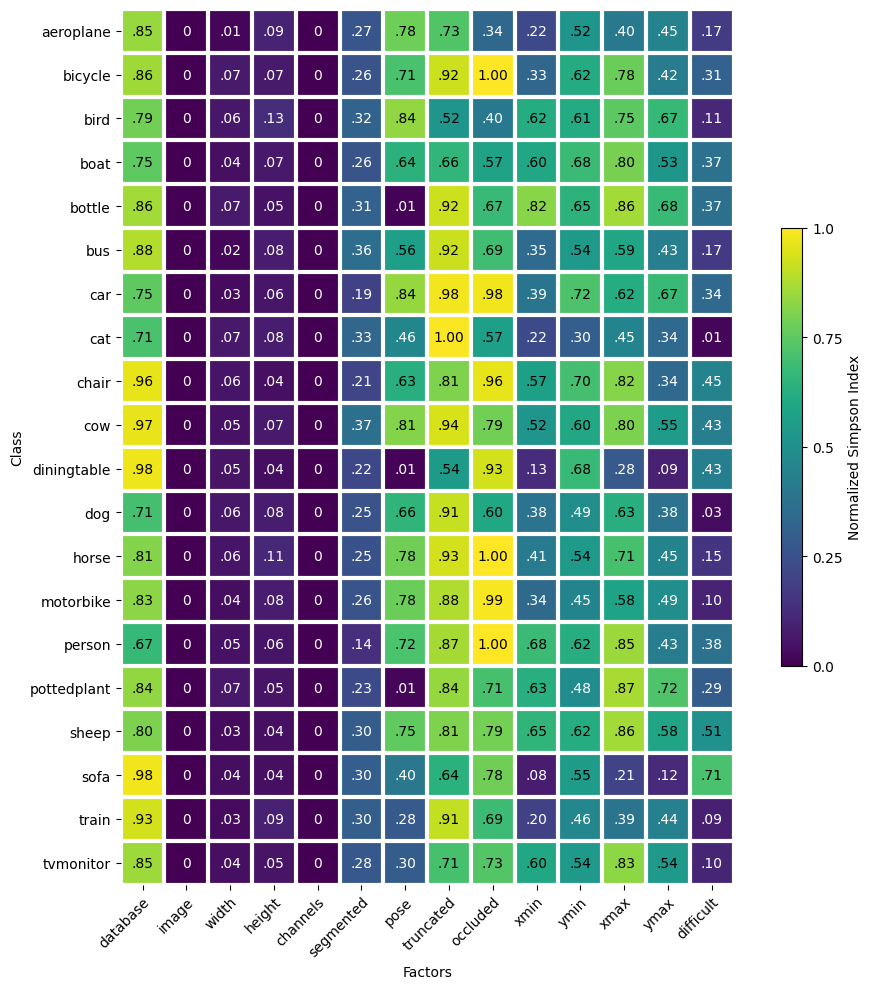

In [17]:
heatmap(
    div.classwise,
    class_list,
    list(metadata_dict.keys()),
    xlabel="Factors",
    ylabel="Class",
    top=False,
    cbarlabel="Normalized Simpson Index",
)

In [18]:
metadata_dict["class"] = list(numerical_labels)

In [19]:
par = parity(metadata_dict)

/dataeval/src/dataeval/_internal/metrics/parity.py:398: UserWarning: The following factors did not meet the recommended 5 occurrences for each value-label combination. 
Recommend rerunning parity after adjusting the following factor-value-label combinations: 
width - value 1 - label 2: 1 occurrences
		label 5: 2 occurrences
		label 6: 2 occurrences
		label 7: 3 occurrences
		label 8: 4 occurrences
		label 13: 2 occurrences
		label 17: 3 occurrences
		label 18: 1 occurrences
		label 19: 2 occurrences
	value 2 - label 0: 1 occurrences
		label 1: 1 occurrences
		label 4: 1 occurrences
		label 6: 3 occurrences
		label 8: 2 occurrences
		label 12: 3 occurrences
		label 15: 1 occurrences
		label 17: 1 occurrences
		label 18: 2 occurrences
	value 3 - label 1: 3 occurrences
		label 2: 3 occurrences
		label 3: 1 occurrences
		label 5: 2 occurrences
		label 10: 3 occurrences
		label 17: 3 occurrences
		label 18: 2 occurrences
	value 6 - label 0: 1 occurrences
		label 3: 4 occurrences
		label 5: 

In [20]:
for key, score, value in zip(metadata_dict.keys(), par.score, par.p_value):
    print(f"{key} - {score} : {value}")

database - 990.9291480413286 : 1.5901514201845443e-170
image - 0.0 : 1.0
width - 650.9556465515553 : 8.603462319286266e-52
height - 2876.950802644704 : 2.028132565723607e-248
channels - 0.0 : 1.0
segmented - 158.467420174754 : 5.0341649123830866e-24
pose - 4732.098678412114 : 0.0
truncated - 1413.0167827646442 : 2.0579631133262333e-288
occluded - 1166.6729631368883 : 1.2596454286533082e-235
xmin - 2408.9498775893385 : 8.664331582071373e-224
ymin - 2942.0528191812245 : 1.4926080840048065e-276
xmax - 2555.09852485712 : 1.5433919388293091e-254
ymax - 3649.246723350818 : 0.0
difficult - 529.5252377843947 : 3.52241016852592e-100
